In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
target_gu = '동대문구'
target_dong = '답십리'
#target_purpose = '준주거'
target_building_age = 3
target_period = 36 # in months

In [3]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [4]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210728'

In [5]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [6]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [7]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [8]:
apart_df = data_prep('아파트', '매매')
apart_df['부동산유형'] = '아파트'
print(apart_df.shape)
apart_df.head()

16it [00:01,  8.05it/s]


(1204461, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 655-2,언주로 103,개포2차현대아파트(220),77.75,59500,7,1988,18,2006-03-10,765.273312,33,아파트
1,서울특별시 강남구 개포동 655-2,언주로 103,개포2차현대아파트(220),77.75,60000,6,1988,18,2006-03-29,771.704180,33,아파트
2,서울특별시 강남구 개포동 655-2,언주로 103,개포2차현대아파트(220),77.75,67000,9,1988,18,2006-04-29,861.736334,33,아파트
3,서울특별시 강남구 개포동 655-2,언주로 103,개포2차현대아파트(220),77.75,60000,4,1988,18,2006-06-01,771.704180,33,아파트
4,서울특별시 강남구 개포동 655-2,언주로 103,개포2차현대아파트(220),77.75,72250,5,1988,18,2006-10-20,929.260450,33,아파트


In [9]:
yunrip_df = data_prep('연립다세대', '매매')
yunrip_df['부동산유형'] = '연립다세대'
print(yunrip_df.shape)
yunrip_df.head()

16it [00:01, 11.32it/s]


(645406, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0,연립다세대
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0,연립다세대
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0,연립다세대
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0,연립다세대
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0,연립다세대


In [10]:
officetel_df = data_prep('오피스텔', '매매')
officetel_df['부동산유형'] = '오피스텔'
print(officetel_df.shape)
officetel_df.head()

16it [00:00, 44.84it/s]


(183523, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,6400,8,1997.0,9.0,2006-01-10,197.287300,24.0,오피스텔
1,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7100,7,1997.0,9.0,2006-01-10,218.865598,24.0,오피스텔
2,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7300,11,1997.0,9.0,2006-01-11,225.030826,24.0,오피스텔
3,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,31.91,7500,10,1997.0,9.0,2006-01-18,235.036039,24.0,오피스텔
4,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7400,15,1997.0,9.0,2006-01-19,228.113440,24.0,오피스텔


In [11]:
yunrip_df = yunrip_df.drop(columns=['대지권면적(㎡)'])
house_df = pd.concat([apart_df, yunrip_df, officetel_df]).sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
print(house_df.shape)
house_df.head()

(2033390, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 1164-0,논현로2길 6,골드캐슬,58.05,57500,2,2017.0,1.0,2018-01-20,990.525409,4.0,연립다세대
1,서울특별시 강남구 개포동 1164-0,논현로2길 6,골드캐슬,58.05,57000,1,2017.0,1.0,2018-06-01,981.912145,4.0,연립다세대
2,서울특별시 강남구 개포동 1164-0,논현로2길 6,골드캐슬,58.05,63000,2,2017.0,2.0,2019-01-19,1085.271318,4.0,연립다세대
3,서울특별시 강남구 개포동 1164-12,논현로2길 34,새롬(1164-12),71.72,64500,7,2000.0,17.0,2017-09-23,899.330731,21.0,아파트
4,서울특별시 강남구 개포동 1164-12,논현로2길 34,새롬(1164-12),73.50,29800,4,2000.0,6.0,2006-10-18,405.442177,21.0,아파트


In [12]:
'''land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()'''

"land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')\nprint(land_specs_df.shape)\nland_specs_df.head()"

In [13]:
'''last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()'''

"last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)\nprint(last_df.shape)\nlast_df.head()"

In [14]:
'''house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)'''

"house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)\nprint(house_merge_df.shape)"

In [15]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
#house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
#house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [16]:
target_1_12_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=12)))
    &(house_df['건물연식'] <= 1)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_1_12_df.shape)
target_1_12_df.head()

(104, 14)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
934496,서울특별시 동대문구 답십리동 1015-0,전농로3길 20,답십리엘림퍼스트,52.7678,71500,11,2020.0,1.0,2021-02-04,1354.993007,1.0,아파트,동대문구,답십리동
934497,서울특별시 동대문구 답십리동 1015-0,전농로3길 20,답십리엘림퍼스트,52.7678,65000,3,2020.0,1.0,2021-05-05,1231.811825,1.0,아파트,동대문구,답십리동
934498,서울특별시 동대문구 답십리동 1015-0,전농로3길 20,답십리엘림퍼스트,52.7678,65000,5,2020.0,1.0,2021-05-08,1231.811825,1.0,아파트,동대문구,답십리동
934499,서울특별시 동대문구 답십리동 1015-0,전농로3길 20,답십리엘림퍼스트,52.7678,62000,8,2020.0,1.0,2021-05-25,1174.958971,1.0,아파트,동대문구,답십리동
934500,서울특별시 동대문구 답십리동 1015-0,전농로3길 20,답십리엘림퍼스트,52.9657,68000,12,2020.0,1.0,2021-05-07,1283.849737,1.0,아파트,동대문구,답십리동


In [17]:
target_2_24_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=24)))
    &(house_df['건물연식'] <= 2)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_2_24_df.shape)
target_2_24_df.head()

(308, 14)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
934396,서울특별시 동대문구 답십리동 1013-0,답십리로 141,래미안 미드카운티,59.98,93000,19,2019.0,0.0,2019-11-24,1550.516839,2.0,아파트,동대문구,답십리동
934397,서울특별시 동대문구 답십리동 1013-0,답십리로 141,래미안 미드카운티,59.98,92000,7,2019.0,0.0,2019-12-02,1533.844615,2.0,아파트,동대문구,답십리동
934398,서울특별시 동대문구 답십리동 1013-0,답십리로 141,래미안 미드카운티,59.98,95000,6,2019.0,1.0,2020-01-16,1583.861287,2.0,아파트,동대문구,답십리동
934399,서울특별시 동대문구 답십리동 1013-0,답십리로 141,래미안 미드카운티,59.98,99500,13,2019.0,1.0,2020-02-29,1658.886295,2.0,아파트,동대문구,답십리동
934400,서울특별시 동대문구 답십리동 1013-0,답십리로 141,래미안 미드카운티,59.98,99500,10,2019.0,1.0,2020-02-29,1658.886295,2.0,아파트,동대문구,답십리동


In [18]:
target_3_36_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=36)))
    &(house_df['건물연식'] <= 3)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_3_36_df.shape)
target_3_36_df.head()

(421, 14)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
934319,서울특별시 동대문구 답십리동 1009-0,천호대로55길 11,힐스테이트 청계,48.98,80000,18,2018.0,1.0,2019-10-20,1633.319722,3.0,아파트,동대문구,답십리동
934320,서울특별시 동대문구 답십리동 1009-0,천호대로55길 11,힐스테이트 청계,48.98,79000,6,2018.0,1.0,2019-10-23,1612.903226,3.0,아파트,동대문구,답십리동
934321,서울특별시 동대문구 답십리동 1009-0,천호대로55길 11,힐스테이트 청계,48.98,85500,9,2018.0,2.0,2020-05-02,1745.610453,3.0,아파트,동대문구,답십리동
934322,서울특별시 동대문구 답십리동 1009-0,천호대로55길 11,힐스테이트 청계,48.98,85500,22,2018.0,2.0,2020-05-23,1745.610453,3.0,아파트,동대문구,답십리동
934323,서울특별시 동대문구 답십리동 1009-0,천호대로55길 11,힐스테이트 청계,48.98,82000,3,2018.0,2.0,2020-06-06,1674.152715,3.0,아파트,동대문구,답십리동


In [19]:
target_5_60_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=60)))
    &(house_df['건물연식'] <= 5)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_5_60_df.shape)
target_5_60_df.head()

(638, 14)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
934233,서울특별시 동대문구 답십리동 1006-0,답십리로40길 18,누리마루,29.16,22600,5,2017.0,0.0,2017-07-24,775.034294,4.0,연립다세대,동대문구,답십리동
934234,서울특별시 동대문구 답십리동 1006-0,답십리로40길 18,누리마루,29.16,22600,3,2017.0,0.0,2017-07-24,775.034294,4.0,연립다세대,동대문구,답십리동
934235,서울특별시 동대문구 답십리동 1006-0,답십리로40길 18,누리마루,29.16,22600,3,2017.0,0.0,2017-09-01,775.034294,4.0,연립다세대,동대문구,답십리동
934236,서울특별시 동대문구 답십리동 1006-0,답십리로40길 18,누리마루,29.16,22600,2,2017.0,0.0,2017-09-10,775.034294,4.0,연립다세대,동대문구,답십리동
934237,서울특별시 동대문구 답십리동 1006-0,답십리로40길 18,누리마루,29.16,22600,2,2017.0,0.0,2017-10-15,775.034294,4.0,연립다세대,동대문구,답십리동


In [20]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [21]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [22]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    
    last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
    
    target_upper_limit_df = df[df['계약날짜'] < pd.to_datetime(last_date)]
    target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)
    target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx
    df['지수적용단가'] = df['단가(만원/㎡)']
    df.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']
    df['평가날짜'] = df['계약날짜']
    df.loc[target_upper_limit_df.index, '평가날짜'] = pd.to_datetime(last_date[:-2] + '01')
    
    return df

In [23]:
target_1_12_df = get_index_applied_prices(target_1_12_df)
print(target_1_12_df.shape)
target_1_12_df.head()

(104, 16)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜
934496,서울특별시 동대문구 답십리동 1015-0,전농로3길 20,답십리엘림퍼스트,52.7678,71500,11,2020.0,1.0,2021-02-04,1354.993007,1.0,아파트,동대문구,답십리동,1415.022186,2021-05-01
934497,서울특별시 동대문구 답십리동 1015-0,전농로3길 20,답십리엘림퍼스트,52.7678,65000,3,2020.0,1.0,2021-05-05,1231.811825,1.0,아파트,동대문구,답십리동,1231.811825,2021-05-05
934498,서울특별시 동대문구 답십리동 1015-0,전농로3길 20,답십리엘림퍼스트,52.7678,65000,5,2020.0,1.0,2021-05-08,1231.811825,1.0,아파트,동대문구,답십리동,1231.811825,2021-05-08
934499,서울특별시 동대문구 답십리동 1015-0,전농로3길 20,답십리엘림퍼스트,52.7678,62000,8,2020.0,1.0,2021-05-25,1174.958971,1.0,아파트,동대문구,답십리동,1174.958971,2021-05-25
934500,서울특별시 동대문구 답십리동 1015-0,전농로3길 20,답십리엘림퍼스트,52.9657,68000,12,2020.0,1.0,2021-05-07,1283.849737,1.0,아파트,동대문구,답십리동,1283.849737,2021-05-07


In [24]:
target_2_24_df = get_index_applied_prices(target_2_24_df)
print(target_2_24_df.shape)
target_2_24_df.head()

(308, 16)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜
934396,서울특별시 동대문구 답십리동 1013-0,답십리로 141,래미안 미드카운티,59.98,93000,19,2019.0,0.0,2019-11-24,1550.516839,2.0,아파트,동대문구,답십리동,1789.639657,2021-05-01
934397,서울특별시 동대문구 답십리동 1013-0,답십리로 141,래미안 미드카운티,59.98,92000,7,2019.0,0.0,2019-12-02,1533.844615,2.0,아파트,동대문구,답십리동,1789.408930,2021-05-01
934398,서울특별시 동대문구 답십리동 1013-0,답십리로 141,래미안 미드카운티,59.98,95000,6,2019.0,1.0,2020-01-16,1583.861287,2.0,아파트,동대문구,답십리동,1857.658382,2021-05-01
934399,서울특별시 동대문구 답십리동 1013-0,답십리로 141,래미안 미드카운티,59.98,99500,13,2019.0,1.0,2020-02-29,1658.886295,2.0,아파트,동대문구,답십리동,1910.251590,2021-05-01
934400,서울특별시 동대문구 답십리동 1013-0,답십리로 141,래미안 미드카운티,59.98,99500,10,2019.0,1.0,2020-02-29,1658.886295,2.0,아파트,동대문구,답십리동,1910.251590,2021-05-01


In [25]:
target_3_36_df = get_index_applied_prices(target_3_36_df)
print(target_3_36_df.shape)
target_3_36_df.head()

(421, 16)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜
934319,서울특별시 동대문구 답십리동 1009-0,천호대로55길 11,힐스테이트 청계,48.98,80000,18,2018.0,1.0,2019-10-20,1633.319722,3.0,아파트,동대문구,답십리동,1920.917100,2021-05-01
934320,서울특별시 동대문구 답십리동 1009-0,천호대로55길 11,힐스테이트 청계,48.98,79000,6,2018.0,1.0,2019-10-23,1612.903226,3.0,아파트,동대문구,답십리동,1896.905637,2021-05-01
934321,서울특별시 동대문구 답십리동 1009-0,천호대로55길 11,힐스테이트 청계,48.98,85500,9,2018.0,2.0,2020-05-02,1745.610453,3.0,아파트,동대문구,답십리동,2006.347757,2021-05-01
934322,서울특별시 동대문구 답십리동 1009-0,천호대로55길 11,힐스테이트 청계,48.98,85500,22,2018.0,2.0,2020-05-23,1745.610453,3.0,아파트,동대문구,답십리동,2006.347757,2021-05-01
934323,서울특별시 동대문구 답십리동 1009-0,천호대로55길 11,힐스테이트 청계,48.98,82000,3,2018.0,2.0,2020-06-06,1674.152715,3.0,아파트,동대문구,답십리동,1874.883256,2021-05-01


In [26]:
target_5_60_df = get_index_applied_prices(target_5_60_df)
print(target_5_60_df.shape)
target_5_60_df.head()

(638, 16)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜
934233,서울특별시 동대문구 답십리동 1006-0,답십리로40길 18,누리마루,29.16,22600,5,2017.0,0.0,2017-07-24,775.034294,4.0,연립다세대,동대문구,답십리동,997.576412,2021-05-01
934234,서울특별시 동대문구 답십리동 1006-0,답십리로40길 18,누리마루,29.16,22600,3,2017.0,0.0,2017-07-24,775.034294,4.0,연립다세대,동대문구,답십리동,997.576412,2021-05-01
934235,서울특별시 동대문구 답십리동 1006-0,답십리로40길 18,누리마루,29.16,22600,3,2017.0,0.0,2017-09-01,775.034294,4.0,연립다세대,동대문구,답십리동,1004.739416,2021-05-01
934236,서울특별시 동대문구 답십리동 1006-0,답십리로40길 18,누리마루,29.16,22600,2,2017.0,0.0,2017-09-10,775.034294,4.0,연립다세대,동대문구,답십리동,1004.739416,2021-05-01
934237,서울특별시 동대문구 답십리동 1006-0,답십리로40길 18,누리마루,29.16,22600,2,2017.0,0.0,2017-10-15,775.034294,4.0,연립다세대,동대문구,답십리동,997.706100,2021-05-01


In [27]:
target_1_12_df = target_1_12_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_1_12_df1 = target_1_12_df[['지번주소', '건물(단지)명', '건물연식', '층', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
target_1_12_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가_건물연식1년_최근12개월.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [28]:
target_2_24_df = target_2_24_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_2_24_df1 = target_2_24_df[['지번주소', '건물(단지)명', '건물연식', '층', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
target_2_24_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가_건물연식2년_최근24개월.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [29]:
target_3_36_df = target_3_36_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_3_36_df1 = target_3_36_df[['지번주소', '건물(단지)명', '건물연식', '층', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
target_3_36_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가_건물연식3년_최근36개월.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [30]:
target_5_60_df = target_5_60_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_5_60_df1 = target_5_60_df[['지번주소', '건물(단지)명', '건물연식', '층', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
target_5_60_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가_건물연식5년_최근60개월.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [31]:
target_df = target_3_36_df.copy()

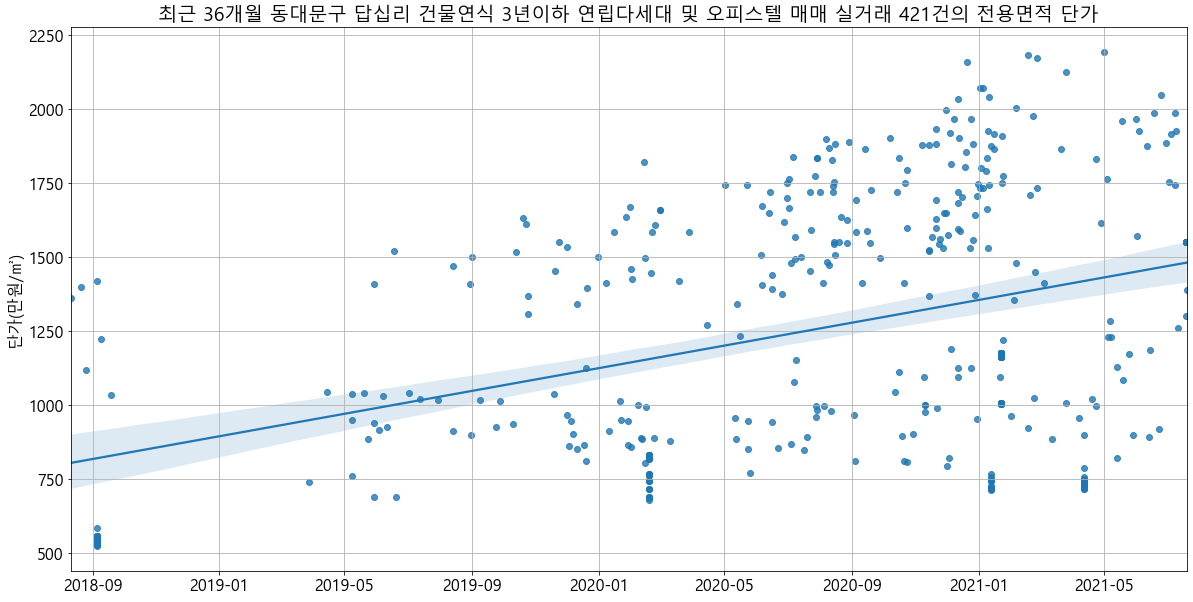

In [32]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/산포도.png'.format(target_gu, target_dong, date_today_record))

In [33]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

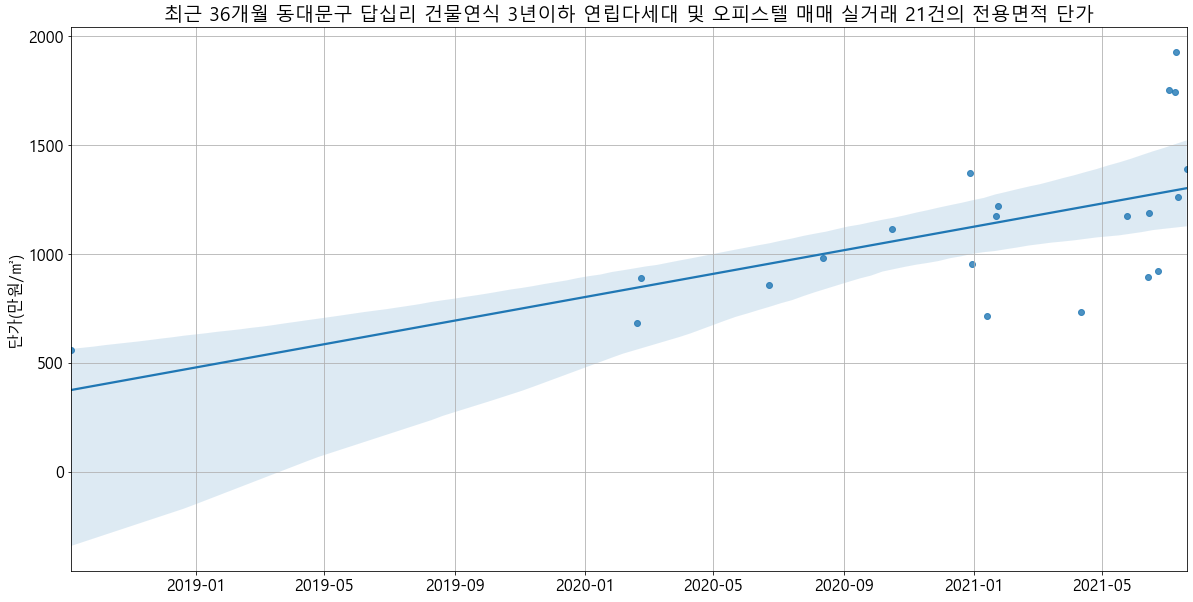

In [34]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/마지막_산포도.png'.format(target_gu, target_dong, date_today_record))

In [35]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [36]:
target_df2 = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(2059, 14)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
931812,서울특별시 동대문구 답십리동 1-119,답십리로59길 57,우성타운,63.04,8000,5,2003.0,3.0,2006-03-17,126.903553,18.0,연립다세대,동대문구,답십리동
932498,서울특별시 동대문구 답십리동 1000-0,한천로37길 33,래미안엘파인아파트,59.95,34900,7,2011.0,0.0,2011-09-06,582.151793,10.0,아파트,동대문구,답십리동
932499,서울특별시 동대문구 답십리동 1000-0,한천로37길 33,래미안엘파인아파트,59.95,34500,14,2011.0,0.0,2011-10-04,575.479566,10.0,아파트,동대문구,답십리동
932500,서울특별시 동대문구 답십리동 1000-0,한천로37길 33,래미안엘파인아파트,59.95,35000,9,2011.0,0.0,2011-11-20,583.819850,10.0,아파트,동대문구,답십리동
932501,서울특별시 동대문구 답십리동 1000-0,한천로37길 33,래미안엘파인아파트,59.95,32800,3,2011.0,1.0,2012-01-25,547.122602,10.0,아파트,동대문구,답십리동


In [37]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'동대문구 답십리 계약날짜기준 건물연식 3년이하 연립다세대 및 오피스텔 매매 실거래 2059건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

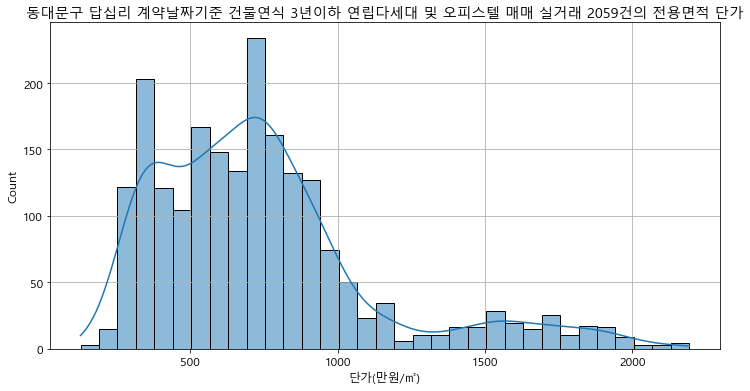

In [38]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [39]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '층', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지수적용_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [40]:
target_df3_30 = target_df3[
    (target_df3['전용면적(㎡)'] >= 28)
    &(target_df3['전용면적(㎡)'] <= 32)
]

In [41]:
target_df3_30.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지수적용_실거래가_30.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [42]:
concat_df = pd.concat([target_df2])

In [43]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [44]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [45]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '평가날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(264, 18)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 동대문구 답십리동 1-119,답십리로59길 57,우성타운,63.04,8000,5,2003.0,3.0,2006-03-17,126.903553,18.0,연립다세대,동대문구,답십리동,316.320204,2021-05-01,126.903553,316.320204
1,서울특별시 동대문구 답십리동 1000-0,한천로37길 33,래미안엘파인아파트,59.95,34800,10,2011.0,3.0,2014-12-27,580.483736,10.0,아파트,동대문구,답십리동,873.215117,2021-05-01,494.031212,742.445871
2,서울특별시 동대문구 답십리동 1000-0,한천로37길 33,래미안엘파인아파트,84.83,40600,11,2011.0,3.0,2014-12-26,478.604267,10.0,아파트,동대문구,답십리동,719.958984,2021-05-01,494.031212,742.445871
3,서울특별시 동대문구 답십리동 1000-0,한천로37길 33,래미안엘파인아파트,84.90,39000,7,2011.0,3.0,2014-12-20,459.363958,10.0,아파트,동대문구,답십리동,691.016004,2021-05-01,494.031212,742.445871
4,서울특별시 동대문구 답십리동 1000-0,한천로37길 33,래미안엘파인아파트,84.94,42000,17,2011.0,3.0,2014-11-15,494.466682,10.0,아파트,동대문구,답십리동,745.589335,2021-05-01,494.031212,742.445871


In [46]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(62, 18)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 동대문구 답십리동 1-119,답십리로59길 57,우성타운,63.0400,8000,5,2003.0,3.0,2006-03-17,126.903553,18.0,연립다세대,동대문구,답십리동,316.320204,2021-05-01,126.903553,316.320204
5,서울특별시 동대문구 답십리동 1000-0,한천로37길 33,래미안엘파인아파트,114.8200,52500,8,2011.0,3.0,2014-09-30,457.237415,10.0,아파트,동대문구,답십리동,682.449917,2021-05-01,494.031212,742.445871
9,서울특별시 동대문구 답십리동 1001-0,답십리로38길 14,한신휴플러스그린파크,114.9800,58400,10,2010.0,1.0,2011-12-01,507.914420,11.0,아파트,동대문구,답십리동,726.847138,2021-05-01,501.770924,749.947069
14,서울특별시 동대문구 답십리동 1002-0,서울시립대로 14,청계한신휴플러스,107.7500,60000,7,2010.0,2.0,2012-03-27,556.844548,11.0,아파트,동대문구,답십리동,796.788512,2021-05-01,582.753668,881.555081
23,서울특별시 동대문구 답십리동 1003-0,답십리로 130,래미안위브,140.6200,90000,9,2014.0,3.0,2017-11-04,640.022756,7.0,아파트,동대문구,답십리동,823.888494,2021-05-01,848.287970,1094.276577
34,서울특별시 동대문구 답십리동 1006-0,답십리로40길 18,누리마루,58.4200,40500,5,2017.0,3.0,2020-09-02,693.255734,4.0,연립다세대,동대문구,답십리동,753.225670,2021-05-01,807.409405,962.698542
37,서울특별시 동대문구 답십리동 1008-0,서울시립대로 19,청계와이즈노벨리아,74.9044,96500,4,2017.0,3.0,2020-11-27,1288.308831,4.0,아파트,동대문구,답십리동,1369.051473,2021-05-01,1311.960639,1456.335927
43,서울특별시 동대문구 답십리동 1009-0,천호대로55길 11,힐스테이트 청계,84.8500,148000,23,2018.0,3.0,2021-07-09,1744.254567,3.0,아파트,동대문구,답십리동,1744.254567,2021-07-09,1892.767545,1953.677875
47,서울특별시 동대문구 답십리동 1013-0,답십리로 141,래미안 미드카운티,84.9900,149000,3,2019.0,2.0,2021-07-03,1753.147429,2.0,아파트,동대문구,답십리동,1753.147429,2021-07-03,1795.476167,1847.668248
52,서울특별시 동대문구 답십리동 1014-0,답십리로56길 105,답십리파크자이,59.9100,115500,11,2019.0,2.0,2021-07-10,1927.891838,2.0,아파트,동대문구,답십리동,1927.891838,2021-07-10,1785.540566,1847.842896


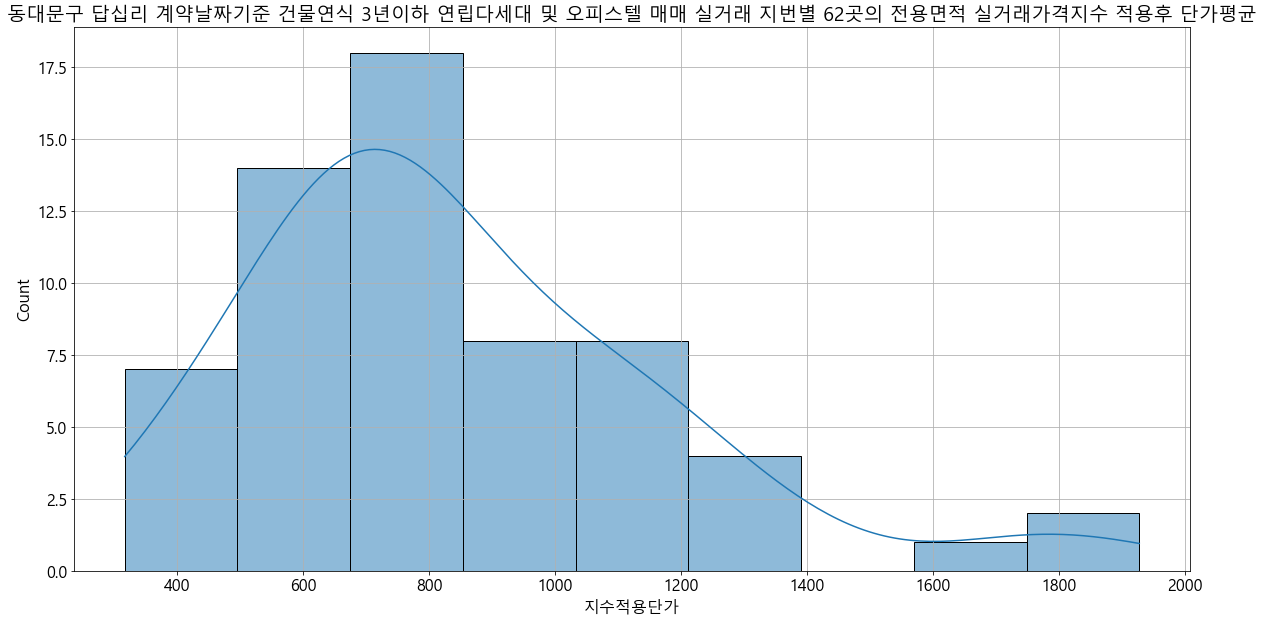

In [47]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지번별_분포도.png'.format(target_gu, target_dong, date_today_record))

In [48]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [49]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '층', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),층,마지막_계약날짜,단가(만원/㎡),평가날짜,지수적용단가,부동산유형
0,서울특별시 동대문구 답십리동 1-119,우성타운,2003.0,63.04,5,2006-03-17,126.903553,2021-05-01,316.320204,연립다세대
1,서울특별시 동대문구 답십리동 1000-0,래미안엘파인아파트,2011.0,114.82,8,2014-09-30,457.237415,2021-05-01,682.449917,아파트
2,서울특별시 동대문구 답십리동 1001-0,한신휴플러스그린파크,2010.0,114.98,10,2011-12-01,507.914420,2021-05-01,726.847138,아파트
3,서울특별시 동대문구 답십리동 1002-0,청계한신휴플러스,2010.0,107.75,7,2012-03-27,556.844548,2021-05-01,796.788512,아파트
4,서울특별시 동대문구 답십리동 1003-0,래미안위브,2014.0,140.62,9,2017-11-04,640.022756,2021-05-01,823.888494,아파트


In [50]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지수적용_마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)